In [134]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [135]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [137]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [138]:
import collections

In [139]:
!pip install apimoex

In [140]:
import requests
import apimoex

session = requests.Session()

In [141]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-5000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE  CLOSE  VOLUME       VALUE
0    TQBR  2013-04-04  48.13  210880  10148463.2
1    TQBR  2013-04-05  47.69  345780  16698661.4
2    TQBR  2013-04-08  47.54  227840  10889442.1
3    TQBR  2013-04-09  47.48  425000  20233800.0
4    TQBR  2013-04-10  46.96  140100   6624780.0


In [142]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [143]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # add a noise
            self.data += np.random.normal(0, 0.05, size = self.data.shape)*self.data
        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1, fee=0.001):
        """
        0 => long   1 => short
        """
        if action == -1:
            action = -3
        elif action == 1:
            action = 1

        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio  fee -- broker fee
        reward = price_diff * action * coef*(1-fee)

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [144]:
# define the nn architecture
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))

            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 5 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)


        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)

    def plot(self):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")

        ax.axis('off')


    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num

    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value

    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)

In [145]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = BioMLP(shp=[state_shape,32,16,action_shape])

        # Let's create an error function
        self.criterion = nn.SmoothL1Loss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=0.00)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size, epoch):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        reg = self.model.get_cc(weight_factor=1.)
        if epoch < 100:
          lambd = 0.000
        else: lambd = 0.003
        loss = self.criterion(outputs, torch.Tensor(current_q_values)) + lambd*reg
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return reg

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [146]:
# number of epochs
epochs = 200
# The significance of the reward is one step ahead
gamma = 0.99
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [147]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 30
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 50
EXP_SIZE = 64
# test size
SIZE_test = 200

In [148]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [149]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [150]:
# We prescribe a new environment and transmit data on the closing price
set_random_seed(1)
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [151]:
def plot_ag():
  actions = []


  for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])
     # We make a schedule of income. Let's make a frame of the Price format/The signal

  dataf = environment.data[::REWARD_TIME]
  backtest = pd.DataFrame({
      'price': dataf.flatten(),
      'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
  })
  # We get price derivatives and make a shift
  backtest['price_diff'] = backtest['price'].diff().shift(-1)
  # We summarize the income and display a graph
  (backtest['price_diff'] * backtest['signal']).cumsum().plot()
  plt.title('Reward')

  plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
  plt.show()


Epoch 0 ... 0.06828579720793529 ... reg 76.581215


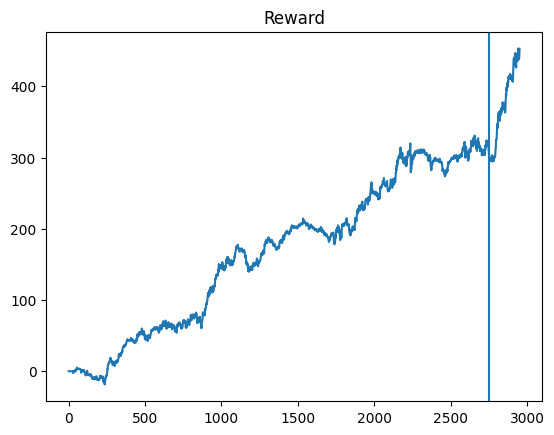

Epoch 1 ... 0.027896396032329174 ... reg 95.49681
Epoch 2 ... 0.026083368846436382 ... reg 99.41084
Epoch 3 ... 0.0332914364437913 ... reg 95.45673
Epoch 4 ... 0.0587802498163116 ... reg 93.41286
Epoch 5 ... 0.05766087068332112 ... reg 96.54096
Epoch 6 ... 0.030318659074210153 ... reg 98.755196
Epoch 7 ... 0.04998303085966199 ... reg 98.6191
Epoch 8 ... 0.08374056943423946 ... reg 99.62645
Epoch 9 ... 0.0464450587803086 ... reg 103.32704
Epoch 10 ... 0.05421098089639979 ... reg 105.06376


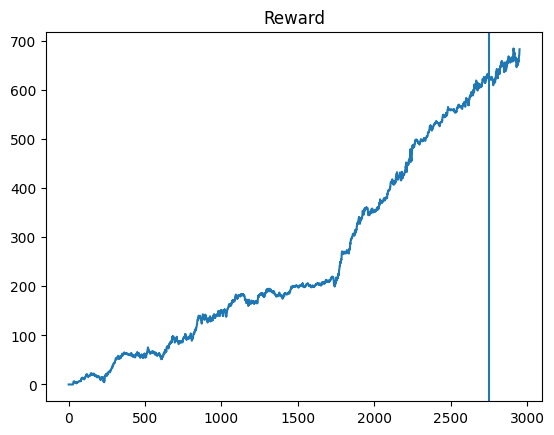

Epoch 11 ... 0.04713870683321079 ... reg 106.17157
Epoch 12 ... 0.08247805657604715 ... reg 106.60208
Epoch 13 ... 0.04809660176340909 ... reg 106.34244
Epoch 14 ... 0.05377056943423956 ... reg 104.30531
Epoch 15 ... 0.04055455547391614 ... reg 105.295456
Epoch 16 ... 0.06596262674504036 ... reg 110.801414
Epoch 17 ... 0.0870216348273328 ... reg 111.28826
Epoch 18 ... 0.10809165319617926 ... reg 115.55378
Epoch 19 ... 0.08308729243203525 ... reg 115.96456
Epoch 20 ... 0.07121453343130062 ... reg 116.38907


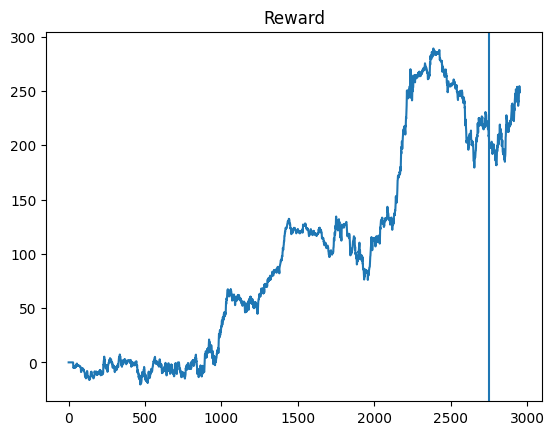

Epoch 21 ... 0.10533541146216023 ... reg 115.987465
Epoch 22 ... 0.07822074577516537 ... reg 117.31058
Epoch 23 ... 0.10556295738427625 ... reg 117.436035
Epoch 24 ... 0.07996771124173409 ... reg 120.84587
Epoch 25 ... 0.10237364437913306 ... reg 121.60948
Epoch 26 ... 0.07148979059515072 ... reg 124.840416
Epoch 27 ... 0.10294984937545922 ... reg 126.48041
Epoch 28 ... 0.0910146987509185 ... reg 126.84559
Epoch 29 ... 0.09815670462894938 ... reg 126.68239
Epoch 30 ... 0.10643644011756068 ... reg 125.5826


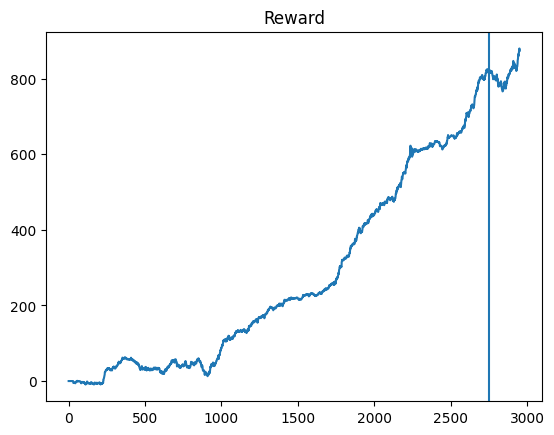

Epoch 31 ... 0.09842095150624537 ... reg 126.45778
Epoch 32 ... 0.07404784717119757 ... reg 126.85161
Epoch 33 ... 0.10554093681116837 ... reg 127.60108
Epoch 34 ... 0.15456240264511392 ... reg 129.49564
Epoch 35 ... 0.11549056576047026 ... reg 130.65266
Epoch 36 ... 0.10212774797942695 ... reg 132.84785
Epoch 37 ... 0.10573545187362235 ... reg 132.70601
Epoch 38 ... 0.09298554004408523 ... reg 133.07127
Epoch 39 ... 0.11771097354886118 ... reg 132.72797
Epoch 40 ... 0.1309343277002205 ... reg 134.29854


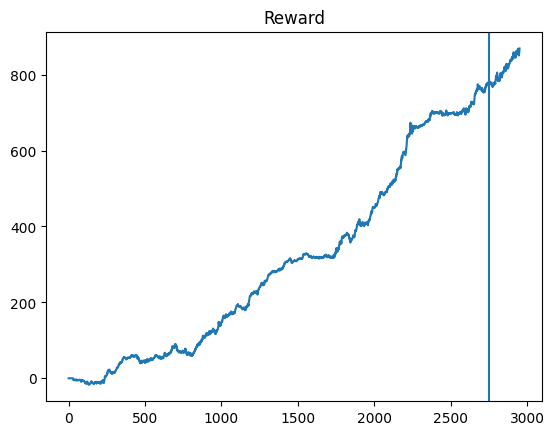

Epoch 41 ... 0.11389774430565762 ... reg 134.98653
Epoch 42 ... 0.1530026120499632 ... reg 136.4149
Epoch 43 ... 0.09007882439382804 ... reg 137.11537
Epoch 44 ... 0.08892274430565766 ... reg 134.11055
Epoch 45 ... 0.08431310433504788 ... reg 134.00005
Epoch 46 ... 0.11375461058045558 ... reg 136.41547
Epoch 47 ... 0.12350972446730343 ... reg 136.33992
Epoch 48 ... 0.13298224099926528 ... reg 138.39806
Epoch 49 ... 0.12569343130051433 ... reg 139.41443
Epoch 50 ... 0.11254347905951506 ... reg 140.43616


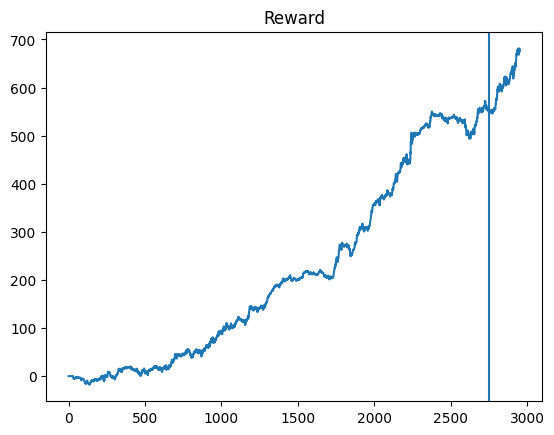

Epoch 51 ... 0.14180148052902278 ... reg 140.4986
Epoch 52 ... 0.1427336847905953 ... reg 143.26057
Epoch 53 ... 0.12662930565760466 ... reg 144.03786
Epoch 54 ... 0.1457101322556943 ... reg 145.2301
Epoch 55 ... 0.11831653930933135 ... reg 144.85953
Epoch 56 ... 0.14019397869213818 ... reg 145.73659
Epoch 57 ... 0.11895513592946372 ... reg 146.53143
Epoch 58 ... 0.119747876561352 ... reg 146.16438
Epoch 59 ... 0.14588262674504038 ... reg 146.1665
Epoch 60 ... 0.1387369507714916 ... reg 147.7378


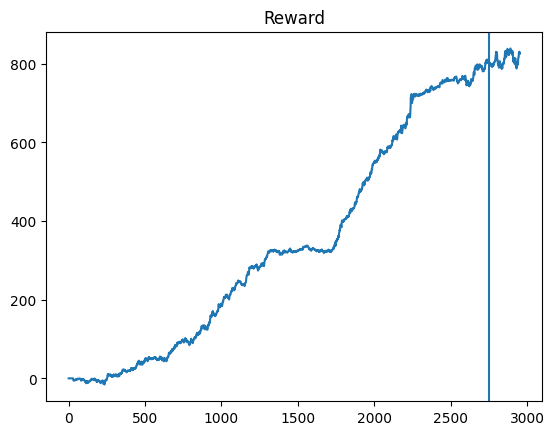

Epoch 61 ... 0.1282918589272594 ... reg 148.4323
Epoch 62 ... 0.13759555106539312 ... reg 148.44548
Epoch 63 ... 0.13328685892725933 ... reg 149.47655
Epoch 64 ... 0.1274514070536371 ... reg 149.75987
Epoch 65 ... 0.11615118295371066 ... reg 150.80066
Epoch 66 ... 0.1315105326965467 ... reg 149.61885
Epoch 67 ... 0.13911864070536378 ... reg 150.93962
Epoch 68 ... 0.1429171895664952 ... reg 151.46321
Epoch 69 ... 0.1324977883908891 ... reg 151.36066
Epoch 70 ... 0.14159595518001467 ... reg 152.5862


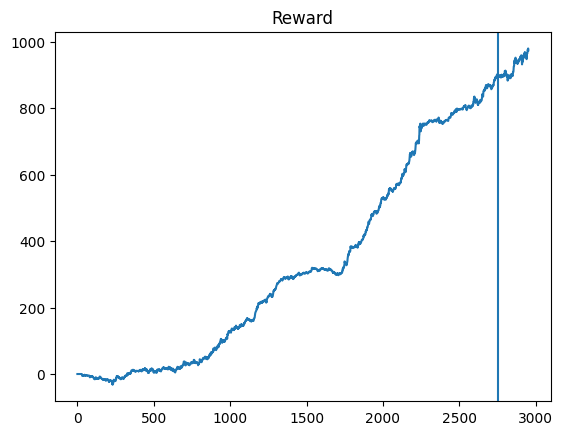

Epoch 71 ... 0.16589565760470235 ... reg 153.59404
Epoch 72 ... 0.16124931667891249 ... reg 155.07143
Epoch 73 ... 0.13618623438648053 ... reg 154.1264
Epoch 74 ... 0.16520934974283613 ... reg 155.65784
Epoch 75 ... 0.15349440484937543 ... reg 156.47874
Epoch 76 ... 0.1463046877296106 ... reg 156.14127
Epoch 77 ... 0.14827919911829535 ... reg 156.68794
Epoch 78 ... 0.1677417156502572 ... reg 156.58797
Epoch 79 ... 0.16305500367376927 ... reg 157.74847
Epoch 80 ... 0.14225290227773696 ... reg 157.74562


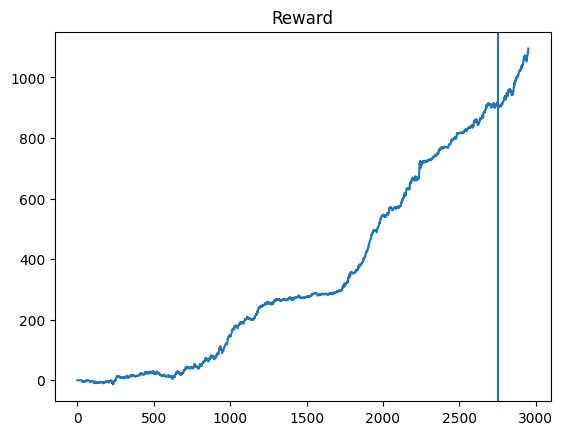

Epoch 81 ... 0.16584427626745044 ... reg 158.4719
Epoch 82 ... 0.15332191036002935 ... reg 159.54448
Epoch 83 ... 0.14843334313005144 ... reg 159.66983
Epoch 84 ... 0.13943426891991179 ... reg 159.99565
Epoch 85 ... 0.1419703049228508 ... reg 160.42526
Epoch 86 ... 0.16842802351212346 ... reg 161.49168
Epoch 87 ... 0.145141267450404 ... reg 162.22023
Epoch 88 ... 0.12798357090374723 ... reg 163.229
Epoch 89 ... 0.142601561351947 ... reg 163.66153
Epoch 90 ... 0.16276873622336513 ... reg 163.95857


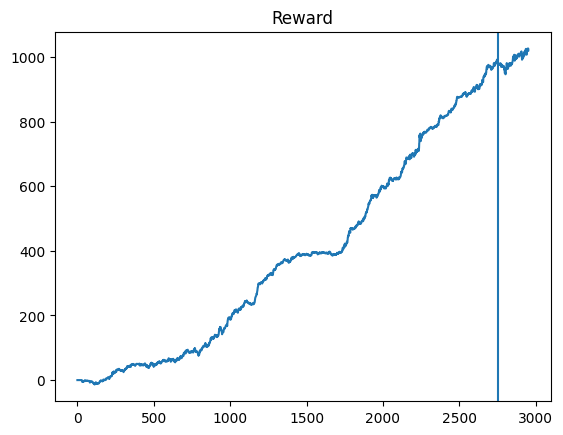

Epoch 91 ... 0.16357248714180744 ... reg 163.69891
Epoch 92 ... 0.13780841660543713 ... reg 164.32227
Epoch 93 ... 0.1654148750918442 ... reg 164.92767
Epoch 94 ... 0.16214849008082288 ... reg 165.86674
Epoch 95 ... 0.14072981263776627 ... reg 166.1656
Epoch 96 ... 0.13707439750183684 ... reg 166.59244
Epoch 97 ... 0.12445293901542973 ... reg 166.35223
Epoch 98 ... 0.149890371050698 ... reg 167.1743
Epoch 99 ... 0.15049960690668615 ... reg 167.33994
Epoch 100 ... 0.13921039309331376 ... reg 160.72699


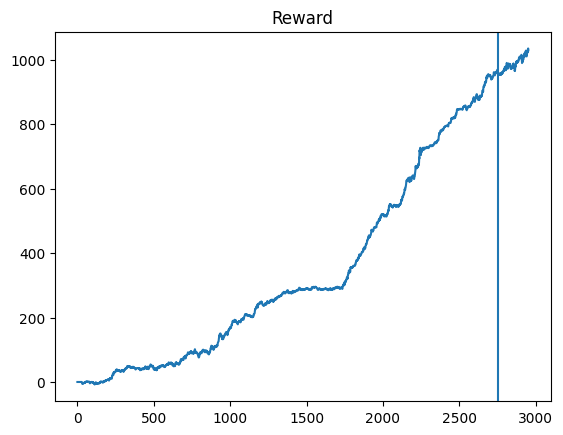

Epoch 101 ... 0.15637175973548859 ... reg 152.09079
Epoch 102 ... 0.1496921858927259 ... reg 144.79823
Epoch 103 ... 0.13158026451138863 ... reg 138.37102
Epoch 104 ... 0.15222822189566496 ... reg 133.31384
Epoch 105 ... 0.1550908963997061 ... reg 128.10213
Epoch 106 ... 0.1527346950771491 ... reg 123.70983
Epoch 107 ... 0.16439458853783978 ... reg 120.39444
Epoch 108 ... 0.147519489346069 ... reg 116.60122
Epoch 109 ... 0.1386415282880235 ... reg 111.86398
Epoch 110 ... 0.16176313005143275 ... reg 109.3727


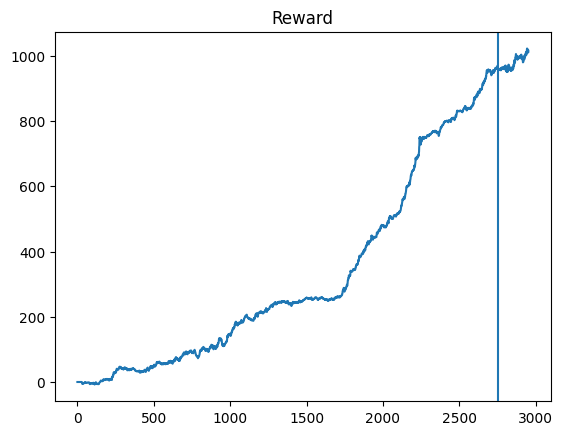

Epoch 111 ... 0.13747443791329897 ... reg 106.051506
Epoch 112 ... 0.16471021675238792 ... reg 104.19373
Epoch 113 ... 0.15285947832476116 ... reg 102.22639
Epoch 114 ... 0.1614695224099926 ... reg 100.028175
Epoch 115 ... 0.1437649816311535 ... reg 96.8059
Epoch 116 ... 0.16546625642909615 ... reg 94.17375
Epoch 117 ... 0.14492106171932403 ... reg 92.64971
Epoch 118 ... 0.1639798677443056 ... reg 91.144455
Epoch 119 ... 0.14107113152094047 ... reg 88.8121
Epoch 120 ... 0.14988670095517995 ... reg 87.196884


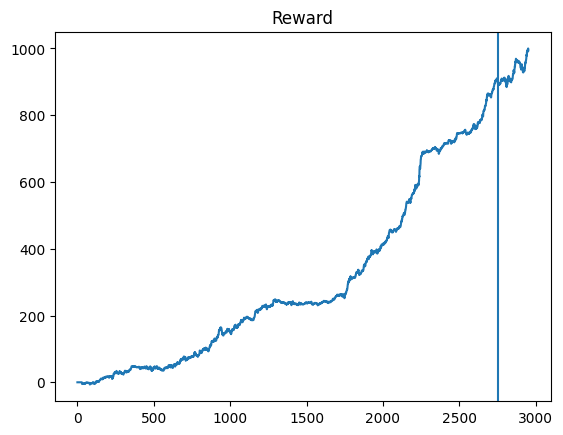

Epoch 121 ... 0.15536248346803816 ... reg 85.965775
Epoch 122 ... 0.1659947501836884 ... reg 84.51436
Epoch 123 ... 0.17833728141072744 ... reg 83.51082
Epoch 124 ... 0.16021067964731814 ... reg 81.549835
Epoch 125 ... 0.17007589639970605 ... reg 80.23589
Epoch 126 ... 0.16513594783247615 ... reg 79.81553
Epoch 127 ... 0.18704274797942688 ... reg 79.4184
Epoch 128 ... 0.16876567229977954 ... reg 78.5032
Epoch 129 ... 0.1769206245407788 ... reg 77.195335
Epoch 130 ... 0.17078422483468036 ... reg 76.327446


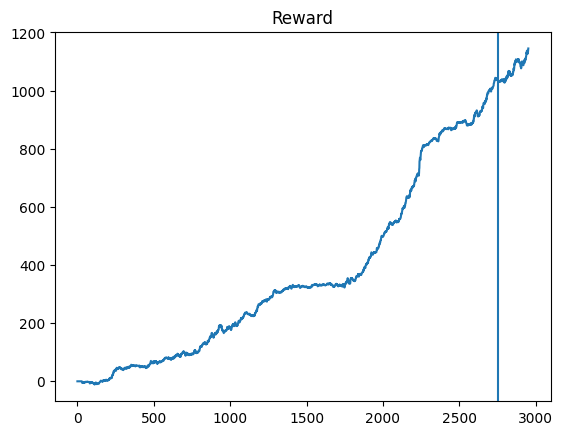

Epoch 131 ... 0.17929150624540782 ... reg 76.96863
Epoch 132 ... 0.19389481631153574 ... reg 77.384384
Epoch 133 ... 0.18580592578986044 ... reg 76.72126
Epoch 134 ... 0.18188993387215285 ... reg 76.62231
Epoch 135 ... 0.18746847905951514 ... reg 76.04491
Epoch 136 ... 0.16783713813372517 ... reg 75.517006
Epoch 137 ... 0.18238906686260095 ... reg 74.72218
Epoch 138 ... 0.19382508449669358 ... reg 74.45184
Epoch 139 ... 0.19320116825863334 ... reg 74.51423
Epoch 140 ... 0.19425448567229978 ... reg 73.87214


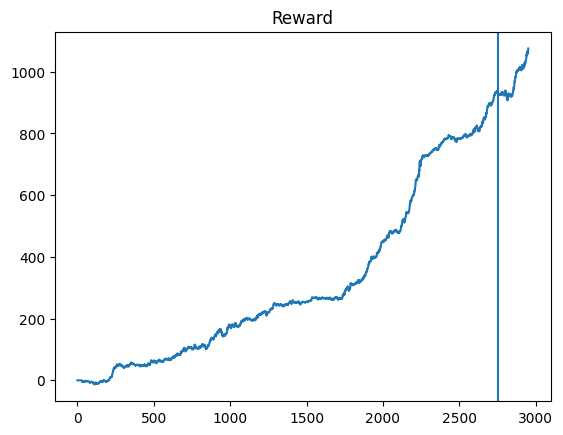

Epoch 141 ... 0.18469755694342388 ... reg 73.47132
Epoch 142 ... 0.18834196179279947 ... reg 72.991615
Epoch 143 ... 0.18470856722997794 ... reg 73.10468
Epoch 144 ... 0.18682988243938284 ... reg 72.73713
Epoch 145 ... 0.19463617560617189 ... reg 72.56587
Epoch 146 ... 0.19692631520940487 ... reg 72.348946
Epoch 147 ... 0.18900624908155766 ... reg 71.70298
Epoch 148 ... 0.1936599301983835 ... reg 71.14773
Epoch 149 ... 0.19219189199118297 ... reg 71.22915
Epoch 150 ... 0.20331962160176337 ... reg 70.647514


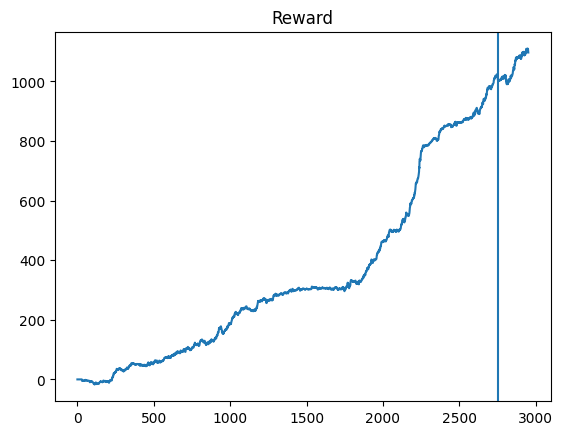

Epoch 151 ... 0.20421512490815577 ... reg 70.42121
Epoch 152 ... 0.1937406722997795 ... reg 70.33904
Epoch 153 ... 0.20091570903747244 ... reg 70.745766
Epoch 154 ... 0.18530312270389412 ... reg 69.67441
Epoch 155 ... 0.1814458523144746 ... reg 69.10591
Epoch 156 ... 0.1855967303453343 ... reg 69.38736
Epoch 157 ... 0.19037886480529015 ... reg 69.25633
Epoch 158 ... 0.20250853049228507 ... reg 70.27199
Epoch 159 ... 0.19205609845701685 ... reg 70.15447
Epoch 160 ... 0.19099177075679638 ... reg 70.3836


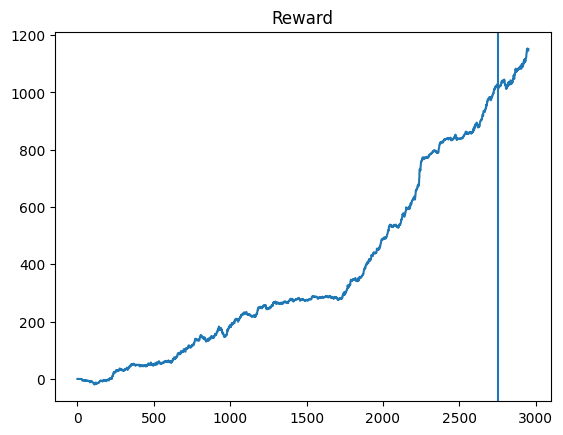

Epoch 161 ... 0.18673078986039668 ... reg 69.93215
Epoch 162 ... 0.20436926891991178 ... reg 69.903336
Epoch 163 ... 0.19300298310066122 ... reg 69.26921
Epoch 164 ... 0.19814111682586327 ... reg 69.49009
Epoch 165 ... 0.19362322924320352 ... reg 69.97894
Epoch 166 ... 0.18429017634092573 ... reg 69.191895
Epoch 167 ... 0.1983319617927994 ... reg 68.67525
Epoch 168 ... 0.2031177663482733 ... reg 68.63957
Epoch 169 ... 0.202347046289493 ... reg 68.64901
Epoch 170 ... 0.19579592578986038 ... reg 68.93209


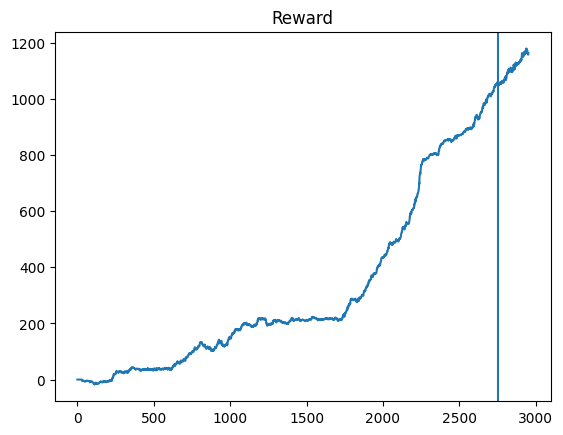

Epoch 171 ... 0.21207279941219687 ... reg 68.53189
Epoch 172 ... 0.21318850844966933 ... reg 68.56107
Epoch 173 ... 0.19552433872152822 ... reg 67.863396
Epoch 174 ... 0.20373434239529759 ... reg 67.691
Epoch 175 ... 0.20013030859662015 ... reg 67.48006
Epoch 176 ... 0.20185892358559884 ... reg 67.527405
Epoch 177 ... 0.1981814878765613 ... reg 67.46119
Epoch 178 ... 0.20224428361498895 ... reg 67.35526
Epoch 179 ... 0.19516466936076415 ... reg 67.86428
Epoch 180 ... 0.18785016899338722 ... reg 67.55407


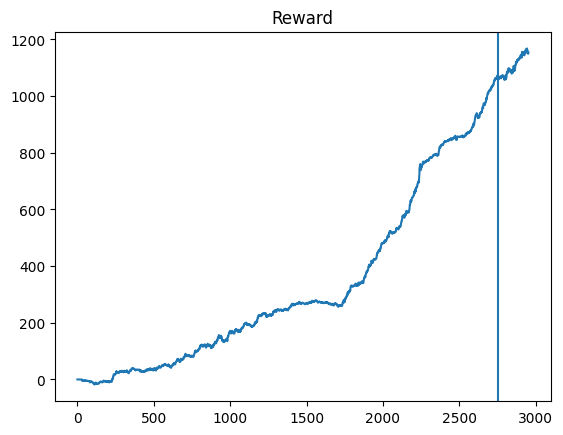

Epoch 181 ... 0.19918342395297578 ... reg 67.313675
Epoch 182 ... 0.1977704371785452 ... reg 67.604294
Epoch 183 ... 0.20631808963997061 ... reg 67.23554
Epoch 184 ... 0.19262863335782518 ... reg 67.053345
Epoch 185 ... 0.20789256061719324 ... reg 66.56561
Epoch 186 ... 0.1943388978692138 ... reg 67.0292
Epoch 187 ... 0.21385646583394566 ... reg 66.615135
Epoch 188 ... 0.20430687729610586 ... reg 67.14285
Epoch 189 ... 0.19355716752387955 ... reg 67.236534
Epoch 190 ... 0.19138080088170467 ... reg 67.23768


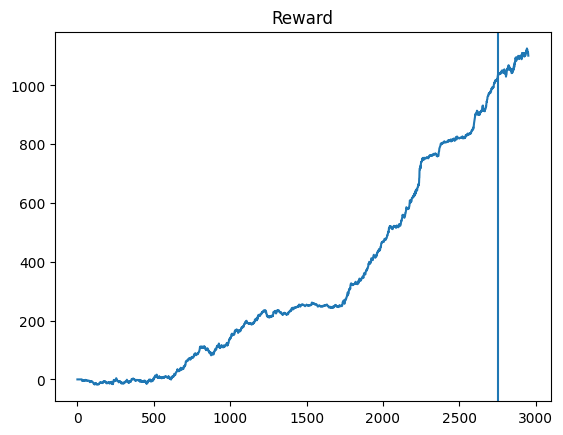

Epoch 191 ... 0.2139298677443057 ... reg 67.38809
Epoch 192 ... 0.19209646950771495 ... reg 67.57433
Epoch 193 ... 0.21783484937545927 ... reg 67.69762
Epoch 194 ... 0.20570518368846447 ... reg 67.97126
Epoch 195 ... 0.19446001102130786 ... reg 68.19176
Epoch 196 ... 0.20867429096252757 ... reg 68.722725
Epoch 197 ... 0.20028812270389426 ... reg 68.222885
Epoch 198 ... 0.21397390889052173 ... reg 68.35229
Epoch 199 ... 0.20465553637031603 ... reg 68.2805


In [152]:
set_random_seed(1)
progress = []


for i in range(epochs):

    learning_progress = []
    reg = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > 5*SAMPLE_SIZE:
            reg.append(agent.replay_experience(gamma, SAMPLE_SIZE,i).detach().numpy())

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon = epsilon*alpha_e

    print('Epoch', i, '...', np.mean(learning_progress),'...','reg',np.mean(reg))
    progress.append(np.mean(learning_progress))
    learning_progress = []
    if i % 10 == 0:
      plot_ag()

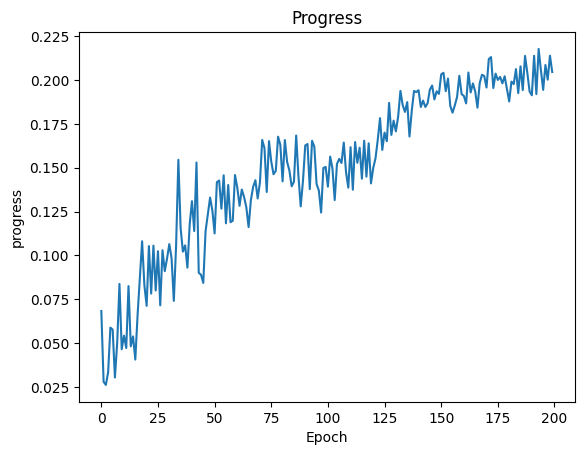

In [153]:
plt.title('Progress')
plt.xlabel('Epoch')
plt.ylabel('progress')
plt.plot(progress)

In [154]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

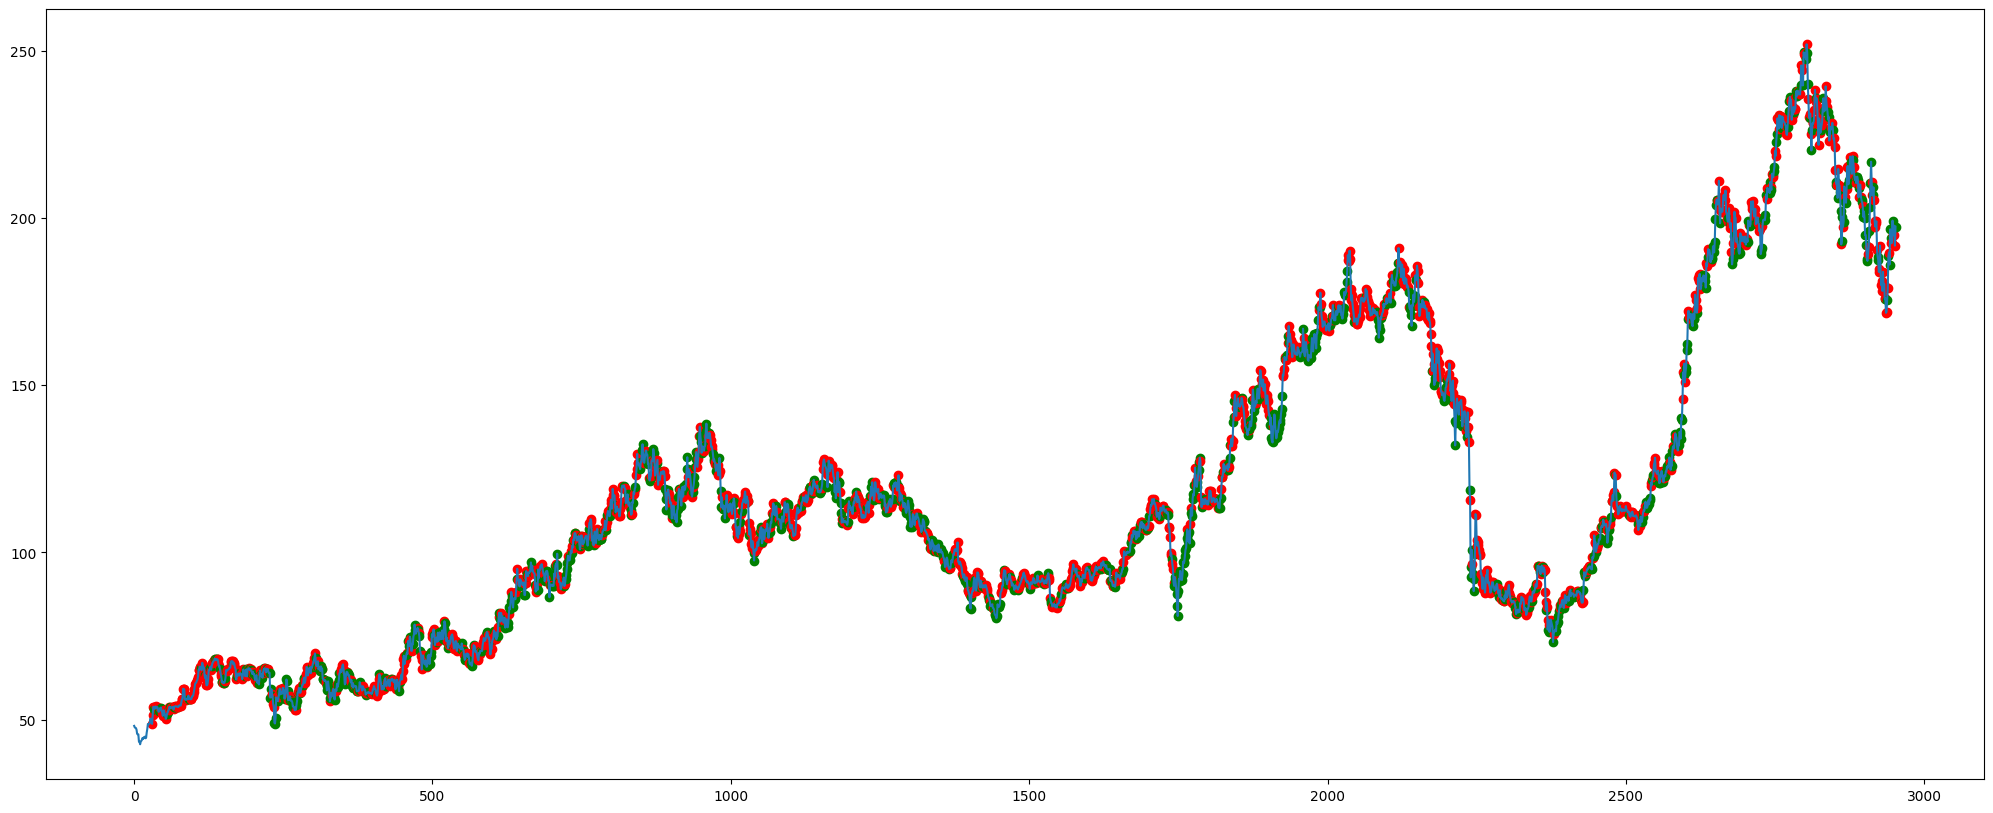

In [155]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

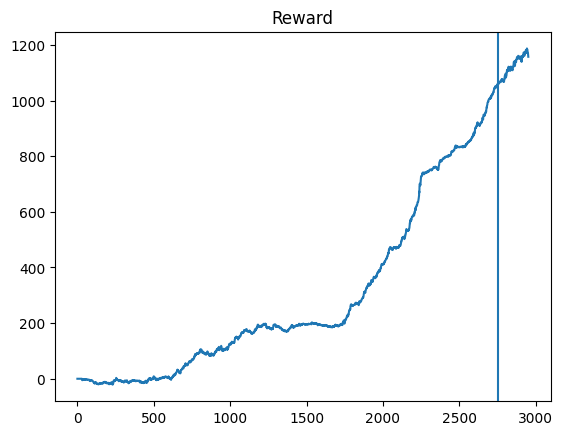

In [156]:
 # We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

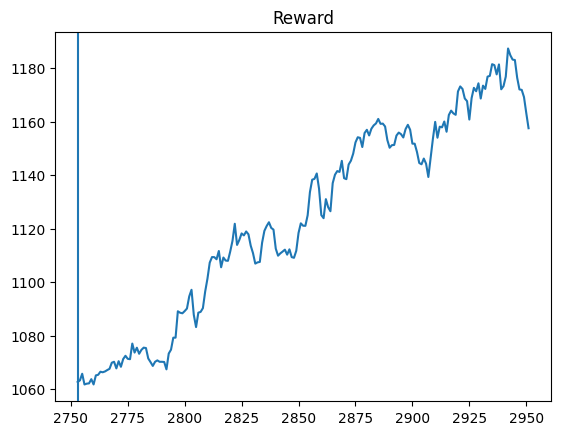

In [157]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum()[-200:].plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()